In [90]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22144 entries, 0 to 22143
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22144 non-null  object 
 1   description               22144 non-null  object 
 2   summary                   22143 non-null  object 
 3   installs                  22144 non-null  object 
 4   minInstalls               22144 non-null  float64
 5   score                     22144 non-null  float64
 6   ratings                   22144 non-null  float64
 7   reviews                   22144 non-null  float64
 8   histogram                 22144 non-null  object 
 9   price                     22144 non-null  float64
 10  free                      22144 non-null  int64  
 11  currency                  22144 non-null  object 
 12  sale                      22144 non-null  bool   
 13  offersIAP                 22144 non-null  bool   
 14  inAppP

In [92]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [93]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [94]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [95]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [96]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [97]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [98]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [99]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

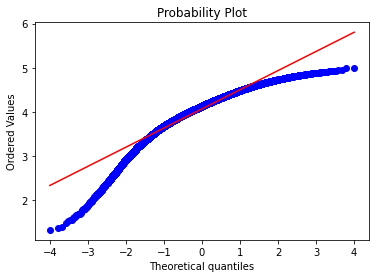

In [100]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22144
- Mean of distribution of rating : 4.06849959255326
- Standard deviation: 0.449479565357854


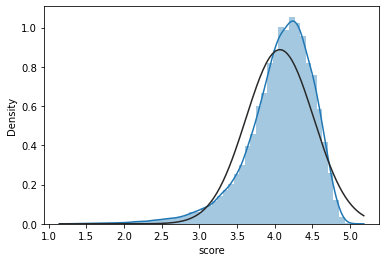

In [101]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

## No pipeline

In [102]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [103]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.42
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [104]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.03
containsAds : 0.01
editorsChoice : 0.07
year : -0.01
top_developer : 0.38
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : -0.00
genre_Art & Design : -0.05
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.19
genre_Board : 0.10
genre_Books & Reference : 0.15
genre_Business : 0.11
genre_Card : 0.19
genre_Casino : 0.19
genre_Casual : -0.05
genre_Comics : -0.12
genre_Communication : 0.07
genre_Dating : 0.03
genre_Education : 0.03
genre_Entertainment : -0.05
genre_Events : -0.34
genre_Finance : 0.10
genre_Food & Drink : 0.11
genre_Health & Fitness : 0.13
genre_House & Home : 0.16
genre_Libraries & Demo : -0.06
genre_Lifestyle : 0.00
genre_Maps & Navigation : 0.12
genre_Medical : 0.06
genre_Music : -0.05
genre_Music & Audio : 0.07
genre_News & Magazines : 0.03
genre_Parenting : 0.16
genre_Personalization : 0.08
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzl

In [105]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [106]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [107]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.657883,2.098828
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.575719,1.949243
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.824297,1.845964
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.802117,1.772017
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.461857,1.765031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21393,3799.0,1,1,0,2020,0,2403.846154,24,1,0.230132,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.726804,3.971010,-0.755794
20715,15535.0,1,1,0,2020,0,2680.965147,191,0,0.218582,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.651341,3.878953,-0.772388
4721,25244.0,1,0,0,2014,0,403.714170,7,0,-0.015406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.597310,3.819693,-0.777617
18652,6204.0,1,1,0,2012,0,311.720698,50,0,0.042329,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.445338,3.665814,-0.779524


In [108]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [109]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,20002.776667,0.990000,0.761667,0.001667,2015.88500,0.026667,904.327906,387.113333,0.281667,0.228591,...,0.005000,0.016667,0.018333,0.006667,0.060000,0.038333,0.150000,3.431380,4.016136,0.584755
std,43292.396307,0.099582,0.426420,0.040825,2.63439,0.161242,895.518766,496.968990,0.450187,0.256407,...,0.070593,0.128126,0.134266,0.081445,0.237685,0.192160,0.357369,0.517053,0.367276,0.303403
min,1001.000000,0.000000,0.000000,0.000000,2010.00000,0.000000,247.647350,0.000000,0.000000,-0.336070,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.559055,3.306605,0.280081
25%,3688.250000,1.000000,1.000000,0.000000,2014.00000,0.000000,421.540745,45.750000,0.000000,0.033630,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.132229,3.751877,0.360258
50%,7281.000000,1.000000,1.000000,0.000000,2016.00000,0.000000,615.954648,193.500000,0.000000,0.185669,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.460648,3.945901,0.491620
75%,15409.500000,1.000000,1.000000,0.000000,2018.00000,0.000000,1051.806678,575.750000,1.000000,0.377925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.771688,4.205344,0.711762
max,366019.000000,1.000000,1.000000,1.000000,2020.00000,1.000000,8403.361345,3206.000000,1.000000,0.910450,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.891700,5.508416,2.098828


In [110]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,...,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,21004.094972,0.995531,0.868156,0.004469,2016.007821,0.088268,934.498219,378.585475,0.368715,0.285418,...,0.005587,0.014525,0.013408,0.011173,0.054749,0.037989,0.153073,4.117171,4.113822,-0.003349
std,25380.048981,0.066740,0.338510,0.066740,2.518154,0.283843,922.974173,502.449015,0.482726,0.171205,...,0.074576,0.119709,0.115078,0.105170,0.227616,0.191276,0.360259,0.295534,0.288749,0.058321
min,1010.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.708695,0.000000,0.000000,-0.199533,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.390698,3.355985,-0.099886
25%,5654.500000,1.000000,1.000000,0.000000,2014.000000,0.000000,425.713378,41.000000,0.000000,0.173172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.914806,3.918394,-0.052857
50%,11499.000000,1.000000,1.000000,0.000000,2016.000000,0.000000,640.614990,164.000000,0.000000,0.292838,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.086854,4.087580,-0.005190
75%,25052.500000,1.000000,1.000000,0.000000,2018.000000,0.000000,991.084171,551.500000,1.000000,0.400021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.281040,4.272696,0.047032
max,161217.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,7407.407407,3133.000000,1.000000,0.865872,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.901379,4.896275,0.099874


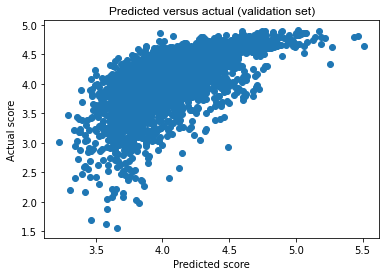

In [111]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

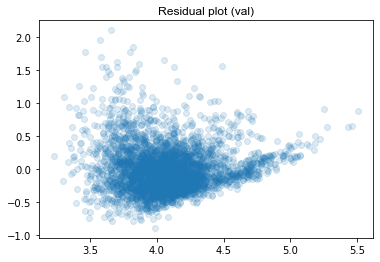

In [112]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings

In [113]:
features2 = features.copy()
features2.remove('ratings')

In [114]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [115]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.14
containsAds : -0.00
editorsChoice : 0.15
year : -0.01
top_developer : 0.46
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.16
genre_Adventure : -0.09
genre_Arcade : 0.02
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.19
genre_Board : 0.10
genre_Books & Reference : 0.14
genre_Business : 0.10
genre_Card : 0.22
genre_Casino : 0.25
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : 0.02
genre_Education : 0.00
genre_Entertainment : -0.07
genre_Events : -0.37
genre_Finance : 0.13
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.12
genre_House & Home : 0.15
genre_Libraries & Demo : -0.08
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.11
genre_Medical : 0.06
genre_Music : -0.03
genre_Music & Audio : 0.06
genre_News & Magazines : 0.02
genre_Parenting : 0.15
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.13
genr

In [116]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [117]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.697273,2.138218
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.564479,1.938003
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.864285,1.834184
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.769028,1.790695
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.471806,1.774981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.821295,-0.762819
20715,15535.0,1,1,0,2020,0,2680.965147,191,0,0.218582,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.651341,3.880440,-0.770901
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.606581,-0.780584
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.816602,-0.824108


## Removing installs / day

In [118]:
features3 = features2.copy()
features3.remove('installs_day')

In [119]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [120]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.14
containsAds : -0.00
editorsChoice : 0.16
year : -0.01
top_developer : 0.46
updated_days : -0.00
has_video : 0.07
compound : 1.16
genre_Adventure : -0.09
genre_Arcade : 0.02
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.07
genre_Beauty : -0.19
genre_Board : 0.10
genre_Books & Reference : 0.14
genre_Business : 0.09
genre_Card : 0.23
genre_Casino : 0.25
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : 0.02
genre_Education : -0.00
genre_Entertainment : -0.07
genre_Events : -0.37
genre_Finance : 0.13
genre_Food & Drink : 0.09
genre_Health & Fitness : 0.11
genre_House & Home : 0.15
genre_Libraries & Demo : -0.08
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.11
genre_Medical : 0.06
genre_Music : -0.03
genre_Music & Audio : 0.06
genre_News & Magazines : 0.02
genre_Parenting : 0.15
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
ge

In [121]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [122]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.699713,2.140658
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.552369,1.925893
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.859139,1.829039
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.770670,1.792337
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.476075,1.779249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.615218,-0.771947
20715,15535.0,1,1,0,2020,0,2680.965147,191,0,0.218582,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.651341,3.868479,-0.782862
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.780190,-0.803924
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.812677,-0.828033


## Removing updated days

In [123]:
features4 = features3.copy()
features4.remove('updated_days')

In [124]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [125]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.15
containsAds : -0.00
editorsChoice : 0.16
year : -0.00
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.09
genre_Arcade : 0.02
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.18
genre_Board : 0.12
genre_Books & Reference : 0.16
genre_Business : 0.12
genre_Card : 0.24
genre_Casino : 0.26
genre_Casual : -0.04
genre_Comics : -0.14
genre_Communication : 0.08
genre_Dating : 0.05
genre_Education : 0.02
genre_Entertainment : -0.05
genre_Events : -0.35
genre_Finance : 0.16
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.13
genre_House & Home : 0.17
genre_Libraries & Demo : -0.08
genre_Lifestyle : 0.01
genre_Maps & Navigation : 0.13
genre_Medical : 0.08
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.06
genre_Parenting : 0.18
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.0

In [126]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [127]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.699713,2.140658
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.552369,1.925893
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.859139,1.829039
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.770670,1.792337
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.476075,1.779249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.615218,-0.771947
20715,15535.0,1,1,0,2020,0,2680.965147,191,0,0.218582,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.651341,3.868479,-0.782862
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.780190,-0.803924
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.812677,-0.828033


## Removing year and mature

In [128]:
features5 = features4.copy()
features5.remove('year')
features5.remove('contentRating_Mature 17+')

In [129]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [130]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.15
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.09
genre_Arcade : 0.02
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.18
genre_Board : 0.13
genre_Books & Reference : 0.17
genre_Business : 0.13
genre_Card : 0.25
genre_Casino : 0.27
genre_Casual : -0.03
genre_Comics : -0.14
genre_Communication : 0.08
genre_Dating : 0.04
genre_Education : 0.03
genre_Entertainment : -0.05
genre_Events : -0.36
genre_Finance : 0.17
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.14
genre_House & Home : 0.18
genre_Libraries & Demo : -0.08
genre_Lifestyle : 0.01
genre_Maps & Navigation : 0.14
genre_Medical : 0.10
genre_Music : -0.02
genre_Music & Audio : 0.08
genre_News & Magazines : 0.07
genre_Parenting : 0.19
genre_Personalization : 0.08
genre_Photography : -0.06
genre_Productivity : 0.09
genre_Puzzle : 0.14
genre_Racing : -0.02
genre_Role Playing : -0.06
genre_Shopp

In [131]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [132]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.698691,2.139636
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.614113,1.987637
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.494873,1.798048
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.826167,1.796067
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.762285,1.783952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.612368,-0.774796
18652,6204.0,1,1,0,2012,0,311.720698,50,0,0.042329,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.445338,3.661737,-0.783601
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.784900,-0.799213
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.822796,-0.817914


## Removing weather and dating

In [133]:
features6 = features5.copy()
features6.remove('genre_Weather')
features6.remove('genre_Dating')

In [134]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [135]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.15
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.01
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.19
genre_Board : 0.11
genre_Books & Reference : 0.16
genre_Business : 0.12
genre_Card : 0.24
genre_Casino : 0.26
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.07
genre_Education : 0.01
genre_Entertainment : -0.06
genre_Events : -0.37
genre_Finance : 0.16
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.13
genre_House & Home : 0.17
genre_Libraries & Demo : -0.09
genre_Lifestyle : 0.00
genre_Maps & Navigation : 0.13
genre_Medical : 0.08
genre_Music : -0.03
genre_Music & Audio : 0.06
genre_News & Magazines : 0.06
genre_Parenting : 0.18
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0.07
genre_Shopping : 0.19
genre_Sim

In [136]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [137]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.697732,2.138677
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.613728,1.987252
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.494004,1.797178
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.826257,1.796156
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.762537,1.784204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.612163,-0.775002
18652,6204.0,1,1,0,2012,0,311.720698,50,0,0.042329,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.445338,3.660324,-0.785014
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.785102,-0.799012
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.824260,-0.816450


## Removing teen and lifestyle

In [138]:
features7 = features6.copy()
features7.remove('contentRating_Teen')
features7.remove('genre_Lifestyle')

In [139]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [140]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.15
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.19
genre_Board : 0.12
genre_Books & Reference : 0.16
genre_Business : 0.12
genre_Card : 0.24
genre_Casino : 0.25
genre_Casual : -0.04
genre_Comics : -0.15
genre_Communication : 0.07
genre_Education : 0.02
genre_Entertainment : -0.06
genre_Events : -0.37
genre_Finance : 0.16
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.14
genre_House & Home : 0.18
genre_Libraries & Demo : -0.08
genre_Maps & Navigation : 0.14
genre_Medical : 0.09
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.06
genre_Parenting : 0.19
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.07
genre_Shopping : 0.19
genre_Simulation : -0.09
genre_S

In [141]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [142]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.693890,2.134835
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.612106,1.985630
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.826432,1.796332
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.485810,1.788984
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.758960,1.780627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9426,39692.0,1,0,0,2011,0,292.483182,37,0,-0.051968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.345238,3.572794,-0.772444
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.609022,-0.778143
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.781469,-0.802644
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.817516,-0.823194


## Removing sports and medical

In [143]:
features8 = features7.copy()
features8.remove('genre_Sports')
features8.remove('genre_Medical')

In [144]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [145]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.15
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.11
genre_Arcade : 0.01
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.19
genre_Board : 0.11
genre_Books & Reference : 0.16
genre_Business : 0.12
genre_Card : 0.24
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.16
genre_Communication : 0.07
genre_Education : 0.01
genre_Entertainment : -0.06
genre_Events : -0.37
genre_Finance : 0.16
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.13
genre_House & Home : 0.17
genre_Libraries & Demo : -0.09
genre_Maps & Navigation : 0.13
genre_Music : -0.03
genre_Music & Audio : 0.06
genre_News & Magazines : 0.06
genre_Parenting : 0.18
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.08
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0.08
genre_Shopping : 0.19
genre_Simulation : -0.10
genre_Social : 0.05
genre_St

In [146]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [147]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.693736,2.134681
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.612093,1.985617
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.826854,1.796754
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.490956,1.794131
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.759028,1.780695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9426,39692.0,1,0,0,2011,0,292.483182,37,0,-0.051968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.345238,3.573301,-0.771937
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.609361,-0.777804
11297,57764.0,1,1,0,2020,0,4464.285714,27,0,0.117752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.584114,3.781595,-0.802518
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.818296,-0.822414


## Dropping casual, education, libraries

In [148]:
features9 = features8.copy()
features9.remove('genre_Casual')
features9.remove('genre_Education')
features9.remove('genre_Libraries & Demo')

In [149]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [150]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.15
containsAds : -0.01
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.18
genre_Board : 0.12
genre_Books & Reference : 0.16
genre_Business : 0.13
genre_Card : 0.24
genre_Casino : 0.25
genre_Comics : -0.15
genre_Communication : 0.08
genre_Entertainment : -0.06
genre_Events : -0.36
genre_Finance : 0.16
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.14
genre_House & Home : 0.18
genre_Maps & Navigation : 0.14
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.06
genre_Parenting : 0.19
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.07
genre_Shopping : 0.19
genre_Simulation : -0.09
genre_Social : 0.05
genre_Strategy : 0.10
genre_Tools : 0.09
genre_Travel & Local : 0.04
genre_Trivia :

In [151]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [152]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.693131,2.134076
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.611130,1.984654
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.828371,1.798270
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.482529,1.785703
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.758271,1.779938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9426,39692.0,1,0,0,2011,0,292.483182,37,0,-0.051968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.345238,3.574814,-0.770424
18652,6204.0,1,1,0,2012,0,311.720698,50,0,0.042329,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.445338,3.674115,-0.771223
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.609915,-0.777249
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.819340,-0.821370


## Removing contains ads and arcade

In [153]:
features10 = features9.copy()
features10.remove('containsAds')
features10.remove('genre_Arcade')

In [154]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred10))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [155]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.16
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.10
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.19
genre_Board : 0.12
genre_Books & Reference : 0.16
genre_Business : 0.13
genre_Card : 0.24
genre_Casino : 0.25
genre_Comics : -0.15
genre_Communication : 0.07
genre_Entertainment : -0.06
genre_Events : -0.36
genre_Finance : 0.17
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.14
genre_House & Home : 0.18
genre_Maps & Navigation : 0.14
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.06
genre_Parenting : 0.19
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.07
genre_Shopping : 0.20
genre_Simulation : -0.09
genre_Social : 0.05
genre_Strategy : 0.10
genre_Tools : 0.08
genre_Travel & Local : 0.04
genre_Trivia : 0.07
genre_Video Players & Editors : -0

In [156]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [157]:
check10.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.696301,2.137246
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.613314,1.986838
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.820939,1.790839
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.487477,1.790652
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.760133,1.781800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18652,6204.0,1,1,0,2012,0,311.720698,50,0,0.042329,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.445338,3.676101,-0.769237
9426,39692.0,1,0,0,2011,0,292.483182,37,0,-0.051968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.345238,3.567189,-0.778049
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.605394,-0.781770
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.812240,-0.828470


## Removing travel & local

In [158]:
features11 = features10.copy()
features11.remove('genre_Travel & Local')

In [159]:
lr11 = LinearRegression()

lr11.fit(X_train[features11], y_train)

y_pred11 = lr11.predict(X_val[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(X_val[features11], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred11))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred11))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


In [160]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features11].columns, lr11.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.16
editorsChoice : 0.16
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.10
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.19
genre_Board : 0.11
genre_Books & Reference : 0.16
genre_Business : 0.13
genre_Card : 0.24
genre_Casino : 0.25
genre_Comics : -0.16
genre_Communication : 0.07
genre_Entertainment : -0.06
genre_Events : -0.37
genre_Finance : 0.16
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.13
genre_House & Home : 0.17
genre_Maps & Navigation : 0.14
genre_Music : -0.02
genre_Music & Audio : 0.07
genre_News & Magazines : 0.06
genre_Parenting : 0.18
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.08
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.08
genre_Shopping : 0.19
genre_Simulation : -0.09
genre_Social : 0.05
genre_Strategy : 0.10
genre_Tools : 0.08
genre_Trivia : 0.07
genre_Video Players & Editors : -0.06
genre_Word : 0.17
conten

In [161]:
check11 = X_val.copy()
check11['score'] = y_val
check11['pred'] = lr11.predict(X_val[features11])
check11['resid'] = check11['pred'] - check11['score']

In [162]:
check11.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
18658,14214.0,1,1,0,2014,0,390.930414,70,1,-0.108331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559055,3.696003,2.136948
16423,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.613576,1.987100
1326,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.490693,1.793867
19824,5985.0,1,0,0,2012,0,308.832613,350,0,0.043856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.030100,3.821142,1.791042
1308,35315.0,1,1,0,2014,0,432.713111,2,0,0.011237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,3.760428,1.782095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18652,6204.0,1,1,0,2012,0,311.720698,50,0,0.042329,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.445338,3.676339,-0.768999
9426,39692.0,1,0,0,2011,0,292.483182,37,0,-0.051968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.345238,3.567485,-0.777753
16311,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.569598,-0.817566
10406,239809.0,1,0,0,2019,0,1908.396947,6,0,0.025267,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.640710,3.813084,-0.827626


### Test

In [163]:
X_test_cont = X_test[['free','editorsChoice','top_developer','has_video','compound']]

In [164]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [165]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [166]:
y_pred_test = lr11.predict(combo_test_df[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(combo_test_df[features11], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27
